### Importation des modules et packages

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import requests 
import urllib
import bs4
import pandas as pd
from urllib import request
import re
from tqdm import tqdm
from scipy import *
!pip install pandas_profiling 
!pip install ipywidgets
from pandas_profiling import ProfileReport

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.2/737.2 kB 18.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.5 MB/s eta 0:00:0000:0100:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=0429e44b06d20ac7097a69f39a6494ea287821cd1f0910a14077baad51df079e
  Stored in directory: /home/onyxia/.cache/pip/wheels/ea/1c/a8/5cec3479cd45136a7111e2d96aac299b219b199c411665250b
Successfully built htmlmin


# Récupération des données 

### WebScrapping des noms de films sur Wikipédia 

On stocke tous les noms des films présents sur cette page dans une liste que l'on appelle Liste_films.
On modifie le format de certains titre : ' XXX (1967)' devient ' XXX '
Finalement, on récupère la longueur de la liste : elle est de ≈ 1500. 

In [2]:
!pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 17.4 MB/s eta 0:00:0000:0100:01


In [3]:
response = requests.get(
	url="https://en.wikipedia.org/wiki/List_of_years_in_film",
)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

List of years in film


In [4]:
all_names= soup.findAll("i")
L=[]
for link in all_names :
    t=link.findAll('a')
    if len(t)!=0:
        r=t[0]['title']
        L.append(r)
# print(L)

In [5]:
# on enlève les précisions entre parenthèses 

Liste_films= []
for i in L: 
    Liste_films.append(re.sub("\(.*?\)","()",i).replace("()",""))
#print(L2)
len(Liste_films)

1537

### Utilisation d'une API pour récupérer l'identifiant des films à partir de leur titre

On utilise l'API: The Movie Database API (TMDB API) pour laquelle j'ai du faire une demande de clé : api_key
On place ces identifiants dans une liste index.

#### CAS PARTICULIER : on fixe le nom du film

In [6]:
# on va utiliser une première requête d'API pour accéder aux ID des films scrappés sur Wikipédia
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 
nom_du_film='Earth '

url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom_du_film}" 
#requête pour trouver les infos ayant le nom_du_film en title 
req = requests.get(url_api)
wb = req.json()


# on récupère tous les indexs des films en question 
index=[]
for film in range(len(wb['results'])):
    index.append(wb['results'][film]['id'])
index  

[811367,
 82700,
 748853,
 5491,
 443297,
 10946,
 55420,
 197624,
 347111,
 68179,
 13363,
 464593,
 88751,
 11569,
 31642,
 641370,
 339,
 246400,
 238603,
 831]

In [7]:
api_key='28c6630049f5d468217e4f34963c03a6' #clé de l'API 

def get_id(nom):
    url_api=f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={nom}" 
    #requête pour trouver les infos ayant le nom_du_film en title 
    req = requests.get(url_api)
    wb = req.json()


    # on récupère tous les indexs des films en question 
    index=[]
    for film in range(len(wb['results'])):
        index.append(wb['results'][film]['id'])
    return(index)



### Récupération du détail des données grâce à une autre API 

Toujours sur TMDB API, on utilise cette fois l'id du film pour accéder à un grand nombre de données sur ce film : get detail. 
Pour cela on fait appel à la fonction précédente qui nous donnait les id correspondant au titre du film. 
On ajuste le format des données pour que les tailles des éléments nous permettent de convertir le dictionnaire
en DataFrame pandas. 

In [8]:
def df_avec_id(id):
    id_film= id
    url_new_api = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={api_key}&language=en-US"
    req_new = requests.get(url_new_api)
    wb_new = req_new.json()
    
    
    #ajustement des données 
    if wb_new['belongs_to_collection']!=None: 
        wb_new['belongs_to_collection']=wb_new['belongs_to_collection']['name']
        
    wb_new['genres']=' , '.join([x['name'] for x in wb_new['genres']]) #on ne sélectionne que le nom des genres 
    wb_new['production_companies']=' , '.join([x['name'] for x in wb_new['production_companies']]) #on ne sélectionne que les noms (même pas les pays)
    wb_new['production_countries']=' , '.join([x['name'] for x in wb_new['production_countries']])
    wb_new['spoken_languages']=' , '.join([x['name'] for x in wb_new['spoken_languages']])
    
    df=pd.DataFrame(wb_new, index=[wb_new['id']])  #j'ai mis l'ID en index mais on peut aussi indexer à partie de 0
    # pour cela, on met index=[0]
    
    return (df)

### Généralisation et concaténation

On utilise les deux fonctions précédentes pour créer notre DataFrame all. 
On parcourt la liste des titres puis la liste des id pour chacun des films. 
On a donc une double-boucle for, ce qui s'avère couteux mais qui fonctionne au bout d'1h30. 

Un axe d'amélioration serait de réduire le temps pour cette collecte de données. 

In [9]:
def concat_all(liste):
    Liste_fail=[]
    
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        for i in ind:
            try:
                df_2=df_avec_id(i)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    DF_ALL=pd.concat([DF_ALL,df_2],axis=0)
                    
            except ValueError:
                Liste_fail.append([nom,i])
    print(Liste_fail)
    return DF_ALL

In [10]:
def concat_all_2(liste):
    Liste_fail=[]
    DF_ALL=pd.DataFrame()
    for nom in tqdm(liste):
        #print(nom)
        ind=get_id(nom)
        f_vect(ind)
    print(Liste_fail)
    return DF_ALL

In [11]:
def fonction_int(id):
    try:
                df_2=df_avec_id(id)
                #print(df_2.budget)
                if df_2['budget'].all()>0:
                    return(pd.DataFrame())
                    
    except ValueError:
                Liste_fail.append(id)
            

f_vect = np.vectorize(fonction_int)

In [12]:
l=Liste_films
a=concat_all(l)

100%|██████████| 1537/1537 [38:02<00:00,  1.49s/it] 

[]


In [14]:
a.head(5)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
603,False,/l4QHerTSbMI7qgvasqxP36pqjN6.jpg,The Matrix Collection,63000000,"Action , Science Fiction",http://www.warnerbros.com/matrix,603,tt0133093,en,The Matrix,...,1999-03-30,463517383,136,English,Released,Welcome to the Real World.,The Matrix,False,8.200,22408
624860,False,/eNI7PtK6DEYgZmHWP9gQNuff8pv.jpg,The Matrix Collection,190000000,"Science Fiction , Action , Adventure",https://www.whatisthematrix.com,624860,tt10838180,en,The Matrix Resurrections,...,2021-12-16,156497322,147,English,Released,Return to the source.,The Matrix Resurrections,False,6.600,4322
604,False,/pxK1iK6anS6erGg4QePmMKbB1E7.jpg,The Matrix Collection,150000000,"Adventure , Action , Thriller , Science Fiction",,604,tt0234215,en,The Matrix Reloaded,...,2003-05-15,738599701,138,English,Released,Free your mind.,The Matrix Reloaded,False,7.025,9435
605,False,/533xAMhhVyjTy8hwMUFEt5TuDfR.jpg,The Matrix Collection,150000000,"Adventure , Action , Thriller , Science Fiction",,605,tt0242653,en,The Matrix Revolutions,...,2003-11-05,424988211,129,"English , Français",Released,Everything that has a beginning has an end.,The Matrix Revolutions,False,6.700,8481
13764,False,/xLDSKsyAGFFCNYDmNynEOsms5jp.jpg,None,50000000,"Family , Fantasy , Adventure",,13764,tt0089961,en,Santa Claus: The Movie,...,1985-10-29,23717291,108,English,Released,Guess who's coming to town!,Santa Claus: The Movie,False,6.300,205


In [ ]:
ProfileReport(df)

# Résolution des problèmes du dataset

Genres

On va créer pour chaque genre une variable "nom du genre" qui vaudra 1 si le film appartient à ce genre et 0 sinon. Cela permettra de résoudre le pb de la multiappartenance

Nationalité

On fait de même qu'avec les genres

Saga

Créer une variable 1 ou 0

# Visualisation des données

Regardons si l'ont peut trouver des liens entre nos données et les revenus générés par les films sélectionnés

Nous utilisons "xlim" et "ylim" pour écarter quelques valeurs extrêmes et avoir une vision plus claire de la plus grande partie de nos données

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

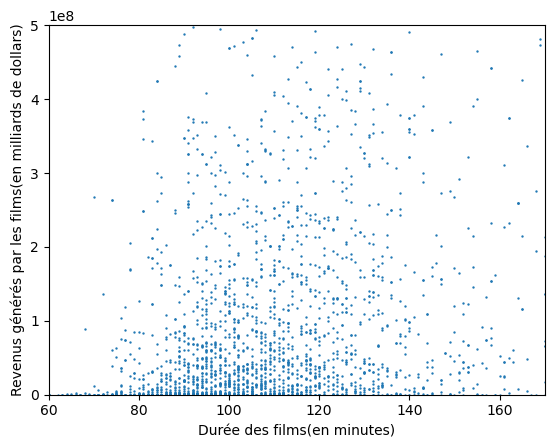

In [51]:
plt.scatter(a["runtime"], a["revenue"], s = 2, marker = ".")
plt.xlim([60, 170])
plt.ylim([0,0.5*10**9])
plt.xlabel("Durée des films(en minutes)")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

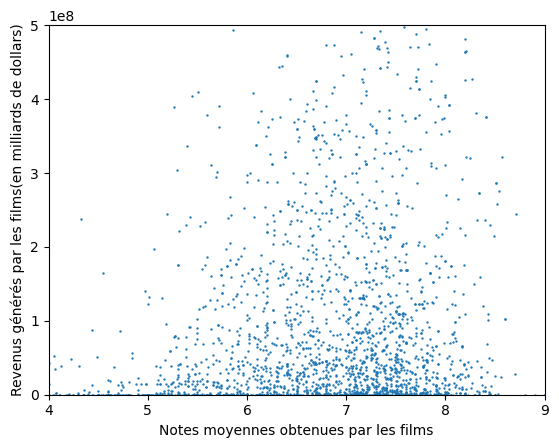

In [52]:
plt.scatter(a["vote_average"], a["revenue"], s = 2, marker = ".")
plt.xlim([4,9])
plt.ylim([0,0.5*10**9])
plt.xlabel("Notes moyennes obtenues par les films")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")

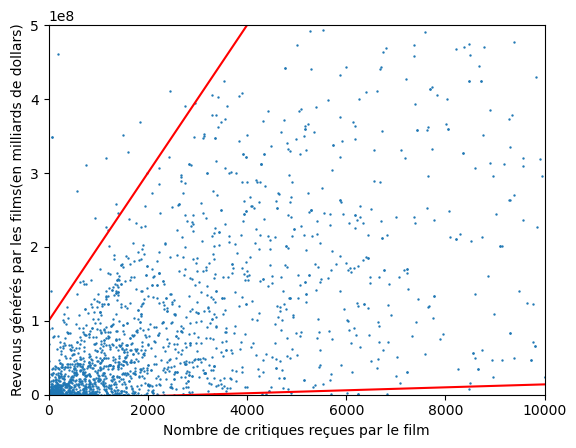

In [79]:
plt.scatter(a["vote_count"], a["revenue"], s = 2, marker = ".")
plt.xlim([0,1*10**4])
plt.ylim([0,0.5*10**9])
plt.xlabel("Nombre de critiques reçues par le film")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")
def f(x):
    return (1*10**5)*x + 1*10**8
plt.plot([f(x) for x in range(10000)], color = "red")
def g(x):
    return 2000*x - 6*10**6
plt.plot([g(x) for x in range(10000)], color = "red")

Text(0, 0.5, 'Revenus générés par les films(en milliards de dollars)')

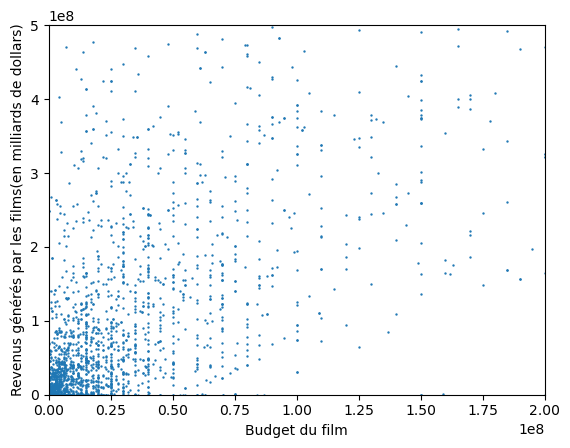

In [84]:
plt.scatter(a["budget"], a["revenue"], s = 2, marker = ".")
plt.xlim([0,2*10**8])
plt.ylim([0,0.5*10**9])
plt.xlabel("Budget du film")
plt.ylabel("Revenus générés par les films(en milliards de dollars)")